In [26]:
import os
import glob
import numpy as np
from PIL import Image
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import sys
import time


In [27]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Define dataset paths
base_path = '/content/drive/MyDrive/FER'
splits = {
    'Train': os.path.join(base_path, 'Train'),
    'Validate': os.path.join(base_path, 'Validate'),
    'Test': os.path.join(base_path, 'Test')
}
sigma = 15  # Noise level σ = 15

In [29]:
# Verify folder existence
for split, path in splits.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Folder not found: {path}")
    print(f"Found {split} folder: {path}")

Found Train folder: /content/drive/MyDrive/FER/Train
Found Validate folder: /content/drive/MyDrive/FER/Validate
Found Test folder: /content/drive/MyDrive/FER/Test


In [30]:
# Function to add Gaussian noise
def add_gaussian_noise(image, sigma):
    img_array = np.array(image).astype(np.float32) / 255.0
    noise = np.random.normal(0, sigma / 255.0, img_array.shape)
    noisy_img = np.clip(img_array + noise, 0, 1) * 255.0
    return Image.fromarray(noisy_img.astype(np.uint8))

In [31]:
# Generate noisy images for Validate and Test (Train already has noisy_sigma15)
for split in ['Validate', 'Test']:
    clean_path = splits[split]
    noisy_path = os.path.join(clean_path, f'noisy_sigma{sigma}')

    # Skip if noisy folder already exists
    if os.path.exists(noisy_path):
        print(f"Noisy folder already exists for {split}: {noisy_path}")
        continue

    # Collect clean images recursively (PNG only)
    clean_files = sorted([
        f for f in glob.glob(os.path.join(clean_path, '**', '*.png'), recursive=True)
        if 'noisy_sigma' not in f
    ])

    if not clean_files:
        raise ValueError(f"No images found in {clean_path}")

    print(f"Processing {split} with sigma={sigma} ({len(clean_files)} images)...")

    for clean_file in clean_files:
        # Load image (grayscale, no resize)
        clean_img = Image.open(clean_file).convert('L')  # Grayscale

        # Verify image size
        if clean_img.size != (48, 48):
            print(f"Warning: Image {clean_file} is {clean_img.size}, expected (48, 48)")

        # Add Gaussian noise
        noisy_img = add_gaussian_noise(clean_img, sigma)

        # Construct output path
        rel_path = os.path.relpath(clean_file, clean_path)
        noisy_file = os.path.join(noisy_path, os.path.basename(clean_file))
        os.makedirs(os.path.dirname(noisy_file), exist_ok=True)

        # Save noisy image as PNG
        noisy_img.save(noisy_file, 'PNG')

        # Save clean image as PNG
        clean_output_file = clean_file
        os.makedirs(os.path.dirname(clean_output_file), exist_ok=True)
        clean_img.save(clean_output_file, 'PNG')

    print(f"Saved {len(clean_files)} noisy (sigma={sigma}) and clean images to {clean_path}")


Noisy folder already exists for Validate: /content/drive/MyDrive/FER/Validate/noisy_sigma15
Noisy folder already exists for Test: /content/drive/MyDrive/FER/Test/noisy_sigma15


In [32]:
# Verify noisy folder for Train
noisy_path_train = os.path.join(splits['Train'], f'noisy_sigma{sigma}')
if not os.path.exists(noisy_path_train):
    raise FileNotFoundError(f"Noisy folder not found for Train: {noisy_path_train}")
print(f"Found noisy folder for Train: {noisy_path_train}")

print("All done! Noisy and clean grayscale images (48x48, sigma=15) are saved in each split.")

Found noisy folder for Train: /content/drive/MyDrive/FER/Train/noisy_sigma15
All done! Noisy and clean grayscale images (48x48, sigma=15) are saved in each split.


In [36]:
# Debug: List contents of base path and splits
print(f"📂 Checking base path: {base_path}")
if os.path.exists(base_path):
    print(f"Contents of {base_path}: {os.listdir(base_path)}")
else:
    raise FileNotFoundError(f"Base path not found: {base_path}")

📂 Checking base path: /content/drive/MyDrive/FER
Contents of /content/drive/MyDrive/FER: ['.DS_Store', 'Test', 'Train', 'Validate']


In [37]:
# Verify folder existence and contents
for split, path in splits.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Folder not found: {path}")
    noisy_path = os.path.join(path, f'noisy_sigma{sigma}')
    if not os.path.exists(noisy_path):
        raise FileNotFoundError(f"Noisy folder not found: {noisy_path}")
    print(f"📂 Found {split} folder: {path}")
    print(f"📂 Contents of {path}: {os.listdir(path)}")
    print(f"📂 Found noisy folder: {noisy_path}")
    print(f"📂 Contents of {noisy_path}: {os.listdir(noisy_path)[:5]} (showing first 5)")

📂 Found Train folder: /content/drive/MyDrive/FER/Train
📂 Contents of /content/drive/MyDrive/FER/Train: ['Training_71983993.jpg', 'Training_39961363.jpg', 'Training_89268024.jpg', 'Training_94116429.jpg', 'Training_83734202.jpg', 'Training_68330823.jpg', 'Training_81674013.jpg', 'Training_79151250.jpg', 'Training_92168412.jpg', 'Training_86666905.jpg', 'Training_7197119.jpg', 'Training_59934667.jpg', 'Training_76550102.jpg', 'Training_75043527.jpg', 'Training_81891525.jpg', 'Training_36611662.jpg', 'Training_80408686.jpg', 'Training_63083301.jpg', 'Training_75305195.jpg', 'Training_36988013.jpg', 'Training_720718.jpg', 'Training_71589001.jpg', 'Training_5949101.jpg', 'Training_35897769.jpg', 'Training_49712783.jpg', 'Training_89588176.jpg', 'Training_72346301.jpg', 'Training_59889098.jpg', 'Training_45649512.jpg', 'Training_5878139.jpg', 'Training_68549907.jpg', 'Training_6940365.jpg', 'Training_92165833.jpg', 'Training_82114119.jpg', 'Training_79943730.jpg', 'Training_5640788.jpg', 'Tr

In [44]:
# PairedNoisyCleanDataset for grayscale images
class PairedNoisyCleanDataset(Dataset):
    def __init__(self, base_dir, split, transform=None):
        self.transform = transform
        split_dir = os.path.join(base_dir, split.capitalize())
        noisy_dir = os.path.join(split_dir, f'noisy_sigma{sigma}')

        # Collect clean images (excluding noisy_sigma15)
        self.clean_images = []
        for root, _, files in os.walk(split_dir):
            if os.path.abspath(root) == os.path.abspath(noisy_dir):
                continue
            for f in files:
                if f.lower().endswith('.jpg'):
                    self.clean_images.append(os.path.join(root, f))

        # Collect noisy images
        self.noisy_images = [
            os.path.join(noisy_dir, f) for f in os.listdir(noisy_dir)
            if f.lower().endswith('.jpg')
        ]

        # Debugging: Print number of images and sample filenames
        print(f"📊 [{split}] Found {len(self.clean_images)} clean images")
        print(f"📊 [{split}] Found {len(self.noisy_images)} noisy images")
        print(f"🖼️ Sample clean images (first 5):")
        for img in self.clean_images[:5]:
            print(f"  - {os.path.basename(img)}")
        print(f"🖼️ Sample noisy images (first 5):")
        for img in self.noisy_images[:5]:
            print(f"  - {os.path.basename(img)}")

        # Match pairs by filename
        clean_dict = {os.path.basename(p): p for p in self.clean_images}
        noisy_dict = {os.path.basename(p): p for p in self.noisy_images}
        self.matched_clean = []
        self.matched_noisy = []
        for fname in noisy_dict:
            if fname in clean_dict:
                self.matched_clean.append(clean_dict[fname])
                self.matched_noisy.append(noisy_dict[fname])
            else:
                print(f"⚠️ Warning: No matching clean image for noisy file {fname}")

        print(f"📊 [{split}] Found {len(self.matched_clean)} paired samples")
        if len(self.matched_clean) == 0:
            print(f"❌ Error: No matched pairs found in {split} dataset!")
            raise ValueError(f"No matched pairs found in {split} dataset!")

        # Print first 5 matched pairs
        print(f"🖼️ First 5 matched clean images for {split}:")
        for img in self.matched_clean[:5]:
            print(f"  - {img}")
        print(f"🖼️ First 5 matched noisy images for {split}:")
        for img in self.matched_noisy[:5]:
            print(f"  - {img}")

        # Verify image size for the first matched image
        if self.matched_clean:
            img = Image.open(self.matched_clean[0]).convert('L')
            if img.size != (48, 48):
                print(f"⚠️ Warning: Sample image {self.matched_clean[0]} is {img.size}, expected (48, 48)")

    def __len__(self):
        return len(self.matched_clean)

    def __getitem__(self, idx):
        noisy_img = Image.open(self.matched_noisy[idx]).convert('L')
        clean_img = Image.open(self.matched_clean[idx]).convert('L')

        if self.transform:
            seed = torch.randint(0, 2**31, (1,)).item()
            torch.manual_seed(seed)
            noisy_img = self.transform(noisy_img)
            torch.manual_seed(seed)
            clean_img = self.transform(clean_img)

        return noisy_img, clean_img

In [45]:
# Define transforms
train_transform = transforms.Compose([
    transforms.RandomCrop(48),  # 48x48 crops
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()  # [1, 48, 48], [0, 1]
])
val_test_transform = transforms.ToTensor()  # [1, 48, 48]

In [46]:
# Create datasets and dataloaders
batch_size = 8
train_dataset = PairedNoisyCleanDataset(base_path, 'train', train_transform)
val_dataset = PairedNoisyCleanDataset(base_path, 'validate', val_test_transform)
test_dataset = PairedNoisyCleanDataset(base_path, 'test', val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"📈 Train dataset size: {len(train_dataset)}")
print(f"📈 Validation dataset size: {len(val_dataset)}")
print(f"📈 Test dataset size: {len(test_dataset)}")

📊 [train] Found 8528 clean images
📊 [train] Found 8528 noisy images
🖼️ Sample clean images (first 5):
  - Training_71983993.jpg
  - Training_39961363.jpg
  - Training_89268024.jpg
  - Training_94116429.jpg
  - Training_83734202.jpg
🖼️ Sample noisy images (first 5):
  - Training_10018621.jpg
  - Training_10031494.jpg
  - Training_10110501.jpg
  - Training_10117992.jpg
  - Training_10118481.jpg
📊 [train] Found 8528 paired samples
🖼️ First 5 matched clean images for train:
  - /content/drive/MyDrive/FER/Train/Training_10018621.jpg
  - /content/drive/MyDrive/FER/Train/Training_10031494.jpg
  - /content/drive/MyDrive/FER/Train/Training_10110501.jpg
  - /content/drive/MyDrive/FER/Train/Training_10117992.jpg
  - /content/drive/MyDrive/FER/Train/Training_10118481.jpg
🖼️ First 5 matched noisy images for train:
  - /content/drive/MyDrive/FER/Train/noisy_sigma15/Training_10018621.jpg
  - /content/drive/MyDrive/FER/Train/noisy_sigma15/Training_10031494.jpg
  - /content/drive/MyDrive/FER/Train/nois

In [47]:
# Debug: Inspect batch structure
for batch in train_loader:
    print("🔍 Batch type:", type(batch))
    print("🔍 Batch length:", len(batch))
    for i, item in enumerate(batch):
        print(f"🔍 Item {i} shape: {item.shape}")
    break

🔍 Batch type: <class 'list'>
🔍 Batch length: 2
🔍 Item 0 shape: torch.Size([8, 1, 48, 48])
🔍 Item 1 shape: torch.Size([8, 1, 48, 48])


In [48]:
# Bi-MSAAE Model for grayscale
class MultiScaleEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=3, padding=1),  # Depthwise
            nn.Conv2d(1, 32, kernel_size=1),  # Pointwise
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=5, padding=2),  # Depthwise
            nn.Conv2d(1, 32, kernel_size=1),  # Pointwise
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        f1 = self.branch3x3(x)  # [batch, 32, 48, 48]
        f2 = self.branch5x5(x)  # [batch, 32, 48, 48]
        return torch.cat([f1, f2], dim=1)  # [batch, 64, 48, 48]

class NoiseGateModule(nn.Module):
    def __init__(self, in_channels=64):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        mask = self.conv(x)  # [batch, 1, 48, 48]
        mask = self.sigmoid(mask)
        return x * mask  # [batch, 64, 48, 48]

class ChannelAttentionBlock(nn.Module):
    def __init__(self, in_channels=64):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.conv = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.avg_pool(x)  # [batch, 64, 1, 1]
        max_out = self.max_pool(x)  # [batch, 64, 1, 1]
        pooled = torch.cat([avg_out, max_out], dim=1)  # [batch, 128, 1, 1]
        attn = self.conv(pooled)  # [batch, 64, 1, 1]
        attn = self.sigmoid(attn)
        return x * attn  # [batch, 64, 48, 48]

class DualHeadDecoder(nn.Module):
    def __init__(self, in_channels=64):
        super().__init__()
        self.structural_head = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )
        self.texture_head = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=5, padding=2),
            nn.BatchNorm2d(1)
        )
        self.alpha = 0.6

    def forward(self, x):
        struct = self.structural_head(x)  # [batch, 1, 48, 48]
        text = self.texture_head(x)  # [batch, 1, 48, 48]
        return self.alpha * struct + (1 - self.alpha) * text  # [batch, 1, 48, 48]

class BiMSAAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = MultiScaleEncoder()
        self.noise_gate = NoiseGateModule()
        self.attention = ChannelAttentionBlock()
        self.decoder = DualHeadDecoder()
        self.skip_conv = nn.Conv2d(64, 64, kernel_size=1)

    def forward(self, x):
        f = self.encoder(x)  # [batch, 64, 48, 48]
        skip = self.skip_conv(f)
        f = self.noise_gate(f)
        f = self.attention(f)
        f = f + skip
        out = self.decoder(f)
        return torch.sigmoid(out)  # [batch, 1, 48, 48]


In [49]:
# Animated Epoch Logger
GREEN = "\033[92m"
YELLOW = "\033[93m"
CYAN = "\033[96m"
RESET = "\033[0m"

def animated_epoch_update(epoch, num_epochs, train_loss, val_loss, psnr, ssim, epoch_time, lr):
    bar_len = 30
    filled_len = int(round(bar_len * (epoch + 1) / num_epochs))
    bar = '█' * filled_len + ' ' * (bar_len - filled_len)
    sys.stdout.write(f"\r{CYAN}Epoch {epoch+1}/{num_epochs} [{bar}] {100*(epoch+1)/num_epochs:.1f}%{RESET}")
    sys.stdout.flush()
    time.sleep(0.1)
    print(f"\n🌟 Training Progress:")
    print(f"  🏋️‍♂️ Train Loss: {train_loss:.6f}")
    print(f"  📉 Val Loss  : {val_loss:.6f}")
    print(f"  📷 PSNR      : {psnr:.2f} dB")
    print(f"  🔍 SSIM      : {ssim:.4f}")
    print(f"  ⏱️ Epoch Time: {epoch_time:.2f} sec")
    print(f"  ⚙️ LR        : {lr:.6e}")
    print("═" * 50)


In [50]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs):
    model.to(device)
    train_dataset = train_loader.dataset
    val_dataset = val_loader.dataset
    total_train_batches = len(train_loader)
    batch_size = train_loader.batch_size or 1

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss = 0.0
        for i, batch in enumerate(train_loader):
            noisy, clean = batch
            noisy, clean = noisy.to(device), clean.to(device)
            optimizer.zero_grad()
            outputs = model(noisy)
            loss = criterion(outputs, clean)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * noisy.size(0)

            if (i + 1) % 100 == 0 or (i + 1) == total_train_batches:
                sys.stdout.write(
                    f"\r{CYAN}Epoch {epoch+1}/{num_epochs} | Batch {i+1}/{total_train_batches} "
                    f"[{100*(i+1)/total_train_batches:.1f}%]{RESET}"
                )
                sys.stdout.flush()

        # Validation every 5 epochs or last
        val_loss, psnr_val, ssim_val = float('nan'), float('nan'), float('nan')
        if epoch % 5 == 4 or epoch == num_epochs - 1:
            model.eval()
            val_loss, psnr_val, ssim_val = 0.0, 0.0, 0.0
            with torch.no_grad():
                val_subset = list(val_loader)[:max(1, len(val_loader) // 5)]
                for noisy, clean in val_subset:
                    noisy, clean = noisy.to(device), clean.to(device)
                    outputs = model(noisy)
                    loss = criterion(outputs, clean)
                    val_loss += loss.item() * noisy.size(0)
                    outputs_np = outputs.cpu().numpy()
                    clean_np = clean.cpu().numpy()
                    for i in range(outputs_np.shape[0]):
                        psnr = peak_signal_noise_ratio(clean_np[i, 0], outputs_np[i, 0], data_range=1.0)
                        ssim = structural_similarity(clean_np[i, 0], outputs_np[i, 0], data_range=1.0)
                        psnr_val += psnr
                        ssim_val += ssim

                n_val = min(len(val_dataset), len(val_subset) * batch_size)
                val_loss /= n_val
                psnr_val /= n_val
                ssim_val /= n_val

            scheduler.step(val_loss)

        avg_train_loss = train_loss / len(train_dataset)
        epoch_time = time.time() - start_time
        current_lr = optimizer.param_groups[0]['lr']

        animated_epoch_update(epoch, num_epochs, avg_train_loss, val_loss, psnr_val, ssim_val, epoch_time, current_lr)

        if (epoch + 1) % 5 == 0:
            checkpoint_path = f'/content/drive/MyDrive/bi_msaae_model_sigma15_48x48_epoch{epoch+1}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f"💾 Checkpoint saved to {checkpoint_path}")

        if psnr_val > 28 and ssim_val > 0.8 and epoch >= 20:
            print(f"🎯 Target metrics (PSNR > 28, SSIM > 0.8) achieved at epoch {epoch+1}. Stopping training.")
            break


In [51]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [53]:
# Initialize model and training setup
from torch.optim.lr_scheduler import ReduceLROnPlateau
model = BiMSAAE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
num_epochs = 50


In [54]:
# Train model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs)


Epoch 1/50 [█                             ] 2.0%
🌟 Training Progress:
  🏋️‍♂️ Train Loss: 0.008378
  📉 Val Loss  : nan
  📷 PSNR      : nan dB
  🔍 SSIM      : nan
  ⏱️ Epoch Time: 116.14 sec
  ⚙️ LR        : 1.000000e-04
══════════════════════════════════════════════════
Epoch 2/50 [█                             ] 4.0%
🌟 Training Progress:
  🏋️‍♂️ Train Loss: 0.004908
  📉 Val Loss  : nan
  📷 PSNR      : nan dB
  🔍 SSIM      : nan
  ⏱️ Epoch Time: 49.66 sec
  ⚙️ LR        : 1.000000e-04
══════════════════════════════════════════════════
Epoch 3/50 [██                            ] 6.0%
🌟 Training Progress:
  🏋️‍♂️ Train Loss: 0.004077
  📉 Val Loss  : nan
  📷 PSNR      : nan dB
  🔍 SSIM      : nan
  ⏱️ Epoch Time: 50.83 sec
  ⚙️ LR        : 1.000000e-04
══════════════════════════════════════════════════
Epoch 4/50 [██                            ] 8.0%
🌟 Training Progress:
  🏋️‍♂️ Train Loss: 0.004003
  📉 Val Loss  : nan
  📷 PSNR      : nan dB
  🔍 SSIM      : nan
  ⏱️ Epoch Time: 51.48 sec


In [55]:
# Save final model
model_path = '/content/drive/MyDrive/bi_msaae_model_sigma15_48x48.pth'
torch.save(model.state_dict(), model_path)
print(f"✅ Training complete. Model saved to {model_path}")

✅ Training complete. Model saved to /content/drive/MyDrive/bi_msaae_model_sigma15_48x48.pth


In [56]:
# Test evaluation
model.eval()
test_loss, psnr_test, ssim_test, inference_times = 0.0, 0.0, 0.0, []
with torch.no_grad():
    for noisy, clean in test_loader:
        noisy, clean = noisy.to(device), clean.to(device)
        start_time = time.time()
        outputs = model(noisy)
        inference_times.append((time.time() - start_time) * 1000 / noisy.size(0))
        loss = criterion(outputs, clean)
        test_loss += loss.item() * noisy.size(0)
        outputs_np = outputs.cpu().numpy()
        clean_np = clean.cpu().numpy()
        for i in range(outputs_np.shape[0]):
            psnr = peak_signal_noise_ratio(clean_np[i, 0], outputs_np[i, 0], data_range=1.0)
            ssim = structural_similarity(clean_np[i, 0], outputs_np[i, 0], data_range=1.0)
            psnr_test += psnr
            ssim_test += ssim

avg_test_loss = test_loss / len(test_dataset)
avg_psnr_test = psnr_test / len(test_dataset)
avg_ssim_test = ssim_test / len(test_dataset)
avg_inference_time = sum(inference_times) / len(inference_times)
print(f"📊 Test Results:")
print(f"  🏋️‍♂️ Test Loss: {avg_test_loss:.6f}")
print(f"  📷 Test PSNR: {avg_psnr_test:.2f} dB")
print(f"  🔍 Test SSIM: {avg_ssim_test:.4f}")
print(f"  ⏱️ Avg Inference Time: {avg_inference_time:.2f} ms")

📊 Test Results:
  🏋️‍♂️ Test Loss: 0.001709
  📷 Test PSNR: 27.74 dB
  🔍 Test SSIM: 0.8966
  ⏱️ Avg Inference Time: 0.39 ms


🖼️ Saving first 5 test images:
  - Clean: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/clean_0.jpg
  - Noisy: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/noisy_0.jpg
  - Denoised: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/denoised_0.jpg
  - Clean: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/clean_1.jpg
  - Noisy: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/noisy_1.jpg
  - Denoised: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/denoised_1.jpg
  - Clean: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/clean_2.jpg
  - Noisy: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/noisy_2.jpg
  - Denoised: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/denoised_2.jpg
  - Clean: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/clean_3.jpg
  - Noisy: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/noisy_3.jpg
  - Denoised: /content/drive/MyDrive/denoised_samples_graysc

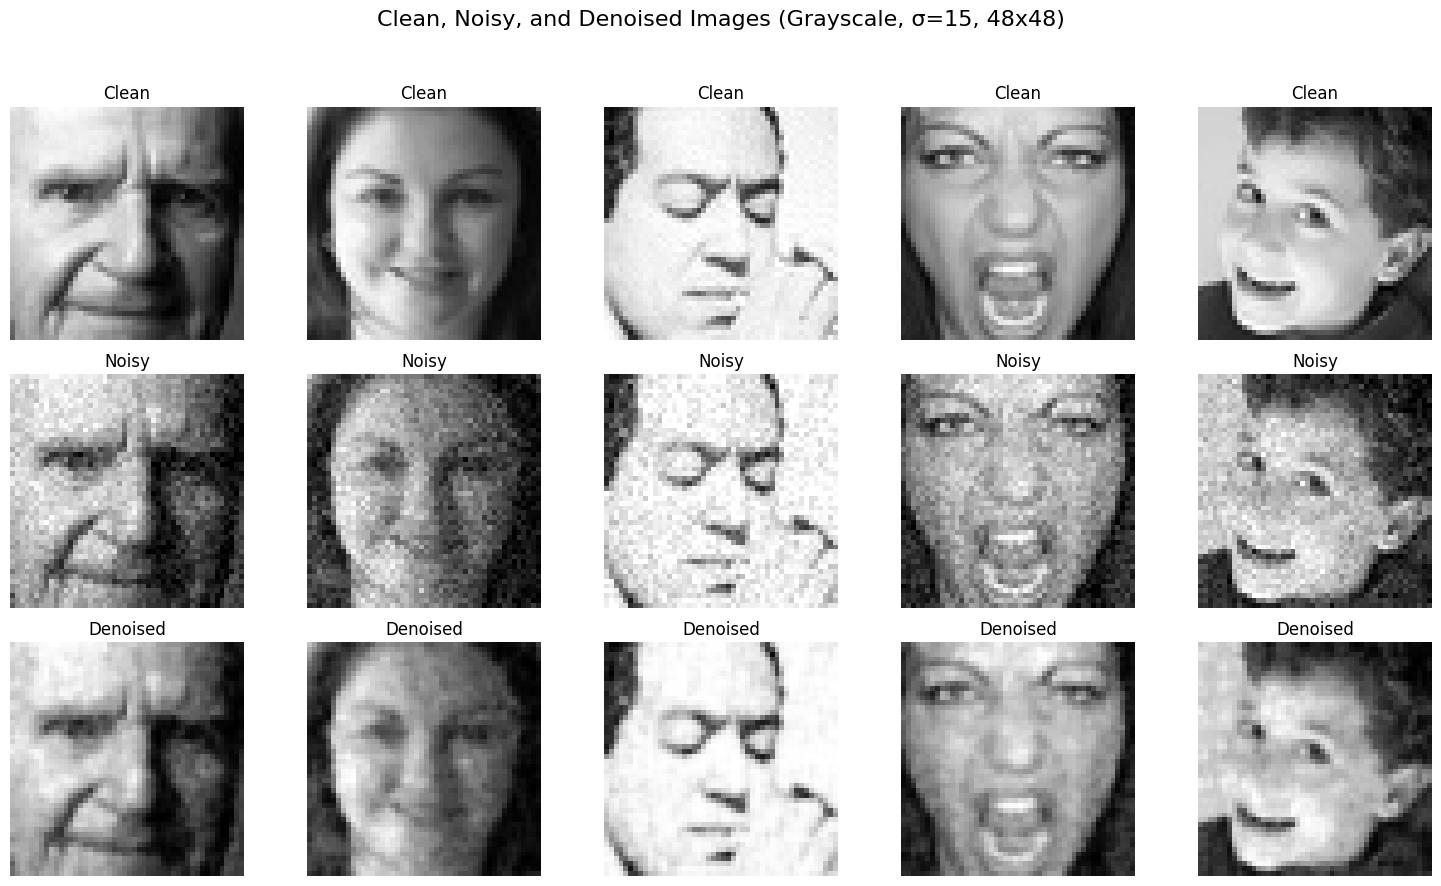

✅ Denoised samples saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15


In [58]:
import os
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Create output directory
output_dir = '/content/drive/MyDrive/denoised_samples_grayscale_sigma15'
os.makedirs(output_dir, exist_ok=True)

model.eval()
with torch.no_grad():
    for i, (noisy, clean) in enumerate(test_loader):
        noisy = noisy.to(device)
        clean = clean.to(device)
        outputs = model(noisy)

        print(f"🖼️ Saving first 5 test images:")
        for j in range(min(5, noisy.size(0))):
            clean_path = os.path.join(output_dir, f'clean_{j}.jpg')
            noisy_path = os.path.join(output_dir, f'noisy_{j}.jpg')
            denoised_path = os.path.join(output_dir, f'denoised_{j}.jpg')

            vutils.save_image(clean[j], clean_path)
            vutils.save_image(noisy[j], noisy_path)
            vutils.save_image(outputs[j], denoised_path)

            print(f"  - Clean: {clean_path}")
            print(f"  - Noisy: {noisy_path}")
            print(f"  - Denoised: {denoised_path}")

        # Display images in order: Clean → Noisy → Denoised
        fig, axes = plt.subplots(3, 5, figsize=(15, 9))
        fig.suptitle('Clean, Noisy, and Denoised Images (Grayscale, σ=15, 48x48)', fontsize=16)
        for j in range(min(5, noisy.size(0))):
            axes[0, j].imshow(clean[j].cpu().squeeze().numpy(), cmap='gray')
            axes[0, j].set_title('Clean', fontsize=12)
            axes[0, j].axis('off')
            axes[1, j].imshow(noisy[j].cpu().squeeze().numpy(), cmap='gray')
            axes[1, j].set_title('Noisy', fontsize=12)
            axes[1, j].axis('off')
            axes[2, j].imshow(outputs[j].cpu().squeeze().numpy(), cmap='gray')
            axes[2, j].set_title('Denoised', fontsize=12)
            axes[2, j].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        break  # Only process the first batch

print(f"✅ Denoised samples saved to {output_dir}")

In [60]:
# Load trained model
model = BiMSAAE().to(device)
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Trained model not found at {model_path}")
model.load_state_dict(torch.load(model_path))
model.eval()
print(f"✅ Loaded trained model from {model_path}")

✅ Loaded trained model from /content/drive/MyDrive/bi_msaae_model_sigma15_48x48.pth


In [61]:
# Detailed evaluation function
def evaluate_model(model, loader, split_name, device):
    model.eval()
    metrics = {
        'Clean vs Denoised PSNR': [],
        'Clean vs Denoised SSIM': [],
        'Clean vs Noisy PSNR': [],
        'Clean vs Noisy SSIM': [],
        'Noisy vs Denoised PSNR': [],
        'Noisy vs Denoised SSIM': [],
        'Inference Time (ms)': []
    }
    mse_loss = 0.0
    criterion = nn.MSELoss()
    sample_images = {'noisy': [], 'clean': [], 'denoised': []}
    max_samples = 5

    with torch.no_grad():
        for i, (noisy, clean) in enumerate(loader):
            noisy, clean = noisy.to(device), clean.to(device)
            start_time = time.time()
            outputs = model(noisy)
            inference_time = (time.time() - start_time) * 1000 / noisy.size(0)
            loss = criterion(outputs, clean)
            mse_loss += loss.item() * noisy.size(0)

            outputs_np = outputs.cpu().numpy()
            clean_np = clean.cpu().numpy()
            noisy_np = noisy.cpu().numpy()

            for j in range(noisy.size(0)):
                clean_img = clean_np[j, 0]
                denoised_img = outputs_np[j, 0]
                noisy_img = noisy_np[j, 0]

                # Compute metrics
                psnr_cd = peak_signal_noise_ratio(clean_img, denoised_img, data_range=1.0)
                ssim_cd = structural_similarity(clean_img, denoised_img, data_range=1.0)
                psnr_cn = peak_signal_noise_ratio(clean_img, noisy_img, data_range=1.0)
                ssim_cn = structural_similarity(clean_img, noisy_img, data_range=1.0)
                psnr_nd = peak_signal_noise_ratio(noisy_img, denoised_img, data_range=1.0)
                ssim_nd = structural_similarity(noisy_img, denoised_img, data_range=1.0)

                metrics['Clean vs Denoised PSNR'].append(psnr_cd)
                metrics['Clean vs Denoised SSIM'].append(ssim_cd)
                metrics['Clean vs Noisy PSNR'].append(psnr_cn)
                metrics['Clean vs Noisy SSIM'].append(ssim_cn)
                metrics['Noisy vs Denoised PSNR'].append(psnr_nd)
                metrics['Noisy vs Denoised SSIM'].append(ssim_nd)
                metrics['Inference Time (ms)'].append(inference_time)

                # Save sample images
                if i * batch_size + j < max_samples:
                    sample_images['noisy'].append(noisy[j])
                    sample_images['clean'].append(clean[j])
                    sample_images['denoised'].append(outputs[j])

    # Compute average metrics
    avg_metrics = {k: np.mean(v) for k, v in metrics.items()}
    mse_loss /= len(loader.dataset)

    # Print detailed results
    print(f"\n📊 Evaluation Results for {split_name} Split:")
    print(f"  🏋️‍♂️ MSE Loss (Clean vs Denoised): {mse_loss:.6f}")
    print(f"  📷 Clean vs Denoised PSNR: {avg_metrics['Clean vs Denoised PSNR']:.2f} dB")
    print(f"  🔍 Clean vs Denoised SSIM: {avg_metrics['Clean vs Denoised SSIM']:.4f}")
    print(f"  📷 Clean vs Noisy PSNR: {avg_metrics['Clean vs Noisy PSNR']:.2f} dB")
    print(f"  🔍 Clean vs Noisy SSIM: {avg_metrics['Clean vs Noisy SSIM']:.4f}")
    print(f"  📷 Noisy vs Denoised PSNR: {avg_metrics['Noisy vs Denoised PSNR']:.2f} dB")
    print(f"  🔍 Noisy vs Denoised SSIM: {avg_metrics['Noisy vs Denoised SSIM']:.4f}")
    print(f"  ⏱️ Avg Inference Time: {avg_metrics['Inference Time (ms)']:.2f} ms")

    # Save metrics to CSV
    metrics_df = pd.DataFrame(metrics)
    csv_path = os.path.join(output_dir, f'{split_name.lower()}_metrics.csv')
    metrics_df.to_csv(csv_path, index=False)
    print(f"📈 Metrics saved to {csv_path}")

    # Plot sample images
    fig, axes = plt.subplots(3, max_samples, figsize=(max_samples * 3, 9))
    fig.suptitle(f'{split_name} Split: Noisy, Denoised, and Clean Images (Grayscale, σ=15, 48x48)', fontsize=16)
    for j in range(min(max_samples, len(sample_images['noisy']))):
        axes[0, j].imshow(sample_images['noisy'][j].cpu().squeeze().numpy(), cmap='gray')
        axes[0, j].set_title('Noisy', fontsize=12)
        axes[0, j].axis('off')
        axes[1, j].imshow(sample_images['denoised'][j].cpu().squeeze().numpy(), cmap='gray')
        axes[1, j].set_title('Denoised', fontsize=12)
        axes[1, j].axis('off')
        axes[2, j].imshow(sample_images['clean'][j].cpu().squeeze().numpy(), cmap='gray')
        axes[2, j].set_title('Clean', fontsize=12)
        axes[2, j].axis('off')

        # Save individual images
        noisy_path = os.path.join(output_dir, f'{split_name.lower()}_noisy_{j}.jpg')
        clean_path = os.path.join(output_dir, f'{split_name.lower()}_clean_{j}.jpg')
        denoised_path = os.path.join(output_dir, f'{split_name.lower()}_denoised_{j}.jpg')
        vutils.save_image(sample_images['noisy'][j], noisy_path)
        vutils.save_image(sample_images['clean'][j], clean_path)
        vutils.save_image(sample_images['denoised'][j], denoised_path)
        print(f"  🖼️ Saved: {noisy_path}")
        print(f"  🖼️ Saved: {clean_path}")
        print(f"  🖼️ Saved: {denoised_path}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    sample_plot_path = os.path.join(output_dir, f'{split_name.lower()}_samples.jpg')
    plt.savefig(sample_plot_path)
    plt.show()
    print(f"📈 Sample images saved to {sample_plot_path}")

    # Plot histograms
    plt.figure(figsize=(15, 10))
    for i, (metric, values) in enumerate(metrics.items(), 1):
        if 'Inference Time' in metric:
            continue
        plt.subplot(2, 3, i)
        sns.histplot(values, bins=50, kde=True)
        plt.title(f'{metric} ({split_name})')
        plt.xlabel(metric)
        plt.ylabel('Count')
    plt.tight_layout()
    hist_plot_path = os.path.join(output_dir, f'{split_name.lower()}_histograms.jpg')
    plt.savefig(hist_plot_path)
    plt.show()
    print(f"📈 Histograms saved to {hist_plot_path}")

    # Plot box plots
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=metrics_df[['Clean vs Denoised PSNR', 'Clean vs Noisy PSNR', 'Noisy vs Denoised PSNR']])
    plt.title(f'PSNR Distribution ({split_name})')
    plt.ylabel('PSNR (dB)')
    plt.tight_layout()
    psnr_box_path = os.path.join(output_dir, f'{split_name.lower()}_psnr_boxplot.jpg')
    plt.savefig(psnr_box_path)
    plt.show()
    print(f"📈 PSNR box plot saved to {psnr_box_path}")

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=metrics_df[['Clean vs Denoised SSIM', 'Clean vs Noisy SSIM', 'Noisy vs Denoised SSIM']])
    plt.title(f'SSIM Distribution ({split_name})')
    plt.ylabel('SSIM')
    plt.tight_layout()
    ssim_box_path = os.path.join(output_dir, f'{split_name.lower()}_ssim_boxplot.jpg')
    plt.savefig(ssim_box_path)
    plt.show()
    print(f"📈 SSIM box plot saved to {ssim_box_path}")

    # Scatter plot: PSNR vs SSIM (Clean vs Denoised)
    plt.figure(figsize=(8, 6))
    plt.scatter(metrics['Clean vs Denoised PSNR'], metrics['Clean vs Denoised SSIM'], alpha=0.5)
    plt.xlabel('PSNR (Clean vs Denoised, dB)')
    plt.ylabel('SSIM (Clean vs Denoised)')
    plt.title(f'PSNR vs SSIM (Clean vs Denoised, {split_name})')
    plt.grid()
    scatter_plot_path = os.path.join(output_dir, f'{split_name.lower()}_psnr_ssim_scatter.jpg')
    plt.savefig(scatter_plot_path)
    plt.show()
    print(f"📈 Scatter plot saved to {scatter_plot_path}")

    return metrics, mse_loss


📊 Evaluation Results for Train Split:
  🏋️‍♂️ MSE Loss (Clean vs Denoised): 0.001727
  📷 Clean vs Denoised PSNR: 27.70 dB
  🔍 Clean vs Denoised SSIM: 0.8962
  📷 Clean vs Noisy PSNR: 24.80 dB
  🔍 Clean vs Noisy SSIM: 0.7914
  📷 Noisy vs Denoised PSNR: 26.76 dB
  🔍 Noisy vs Denoised SSIM: 0.8824
  ⏱️ Avg Inference Time: 0.43 ms
📈 Metrics saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/train_metrics.csv
  🖼️ Saved: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/train_noisy_0.jpg
  🖼️ Saved: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/train_clean_0.jpg
  🖼️ Saved: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/train_denoised_0.jpg
  🖼️ Saved: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/train_noisy_1.jpg
  🖼️ Saved: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/train_clean_1.jpg
  🖼️ Saved: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/train_denoised_1.jpg
  🖼️ Saved: /content/drive/MyDrive/denoise

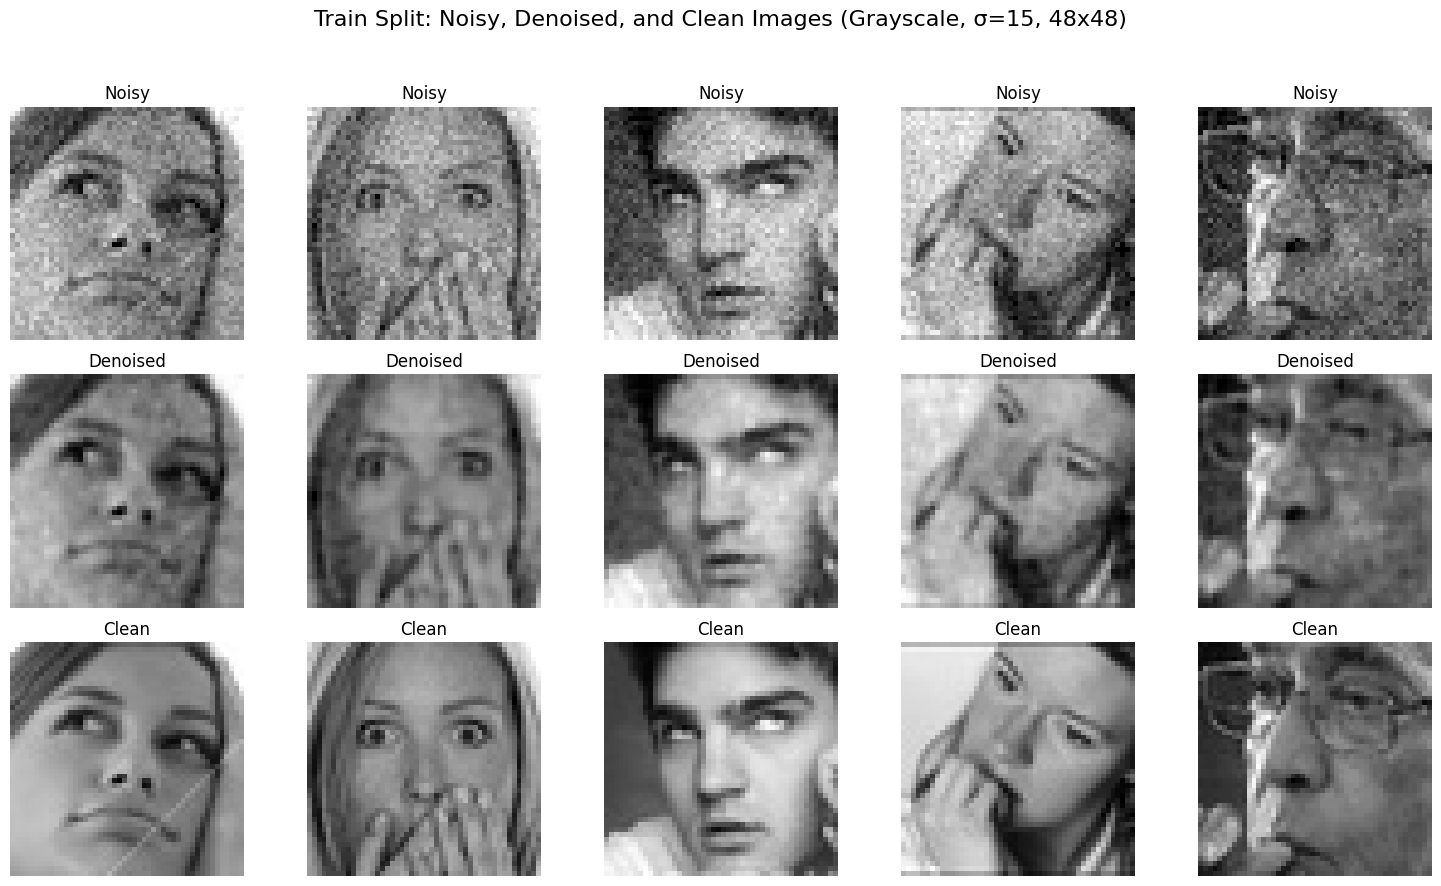

📈 Sample images saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/train_samples.jpg


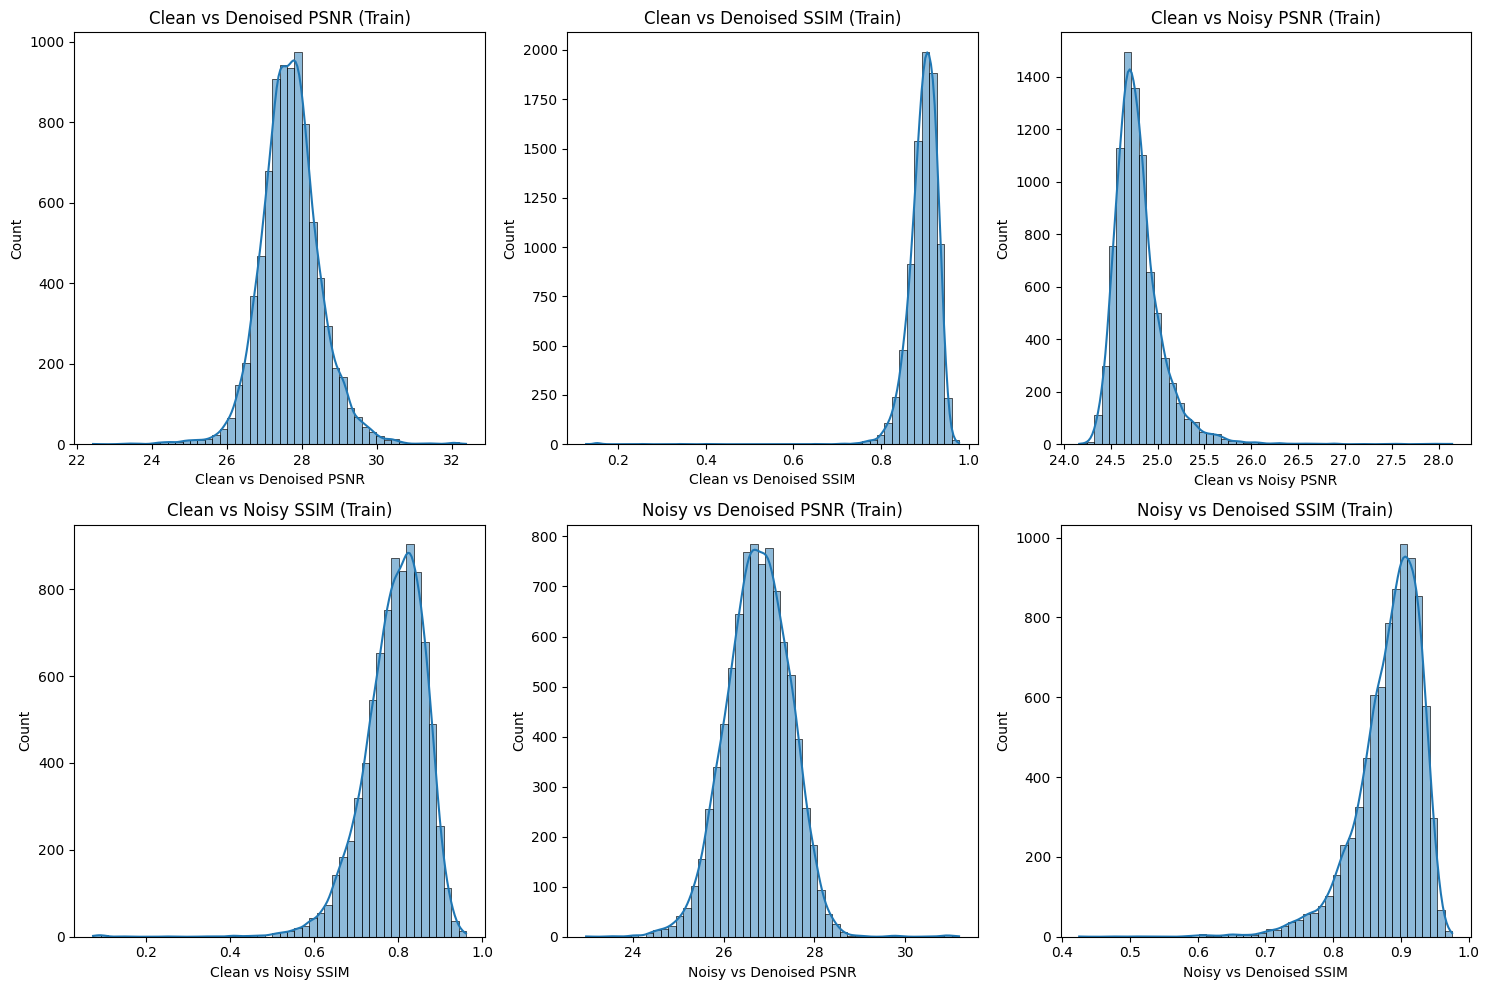

📈 Histograms saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/train_histograms.jpg


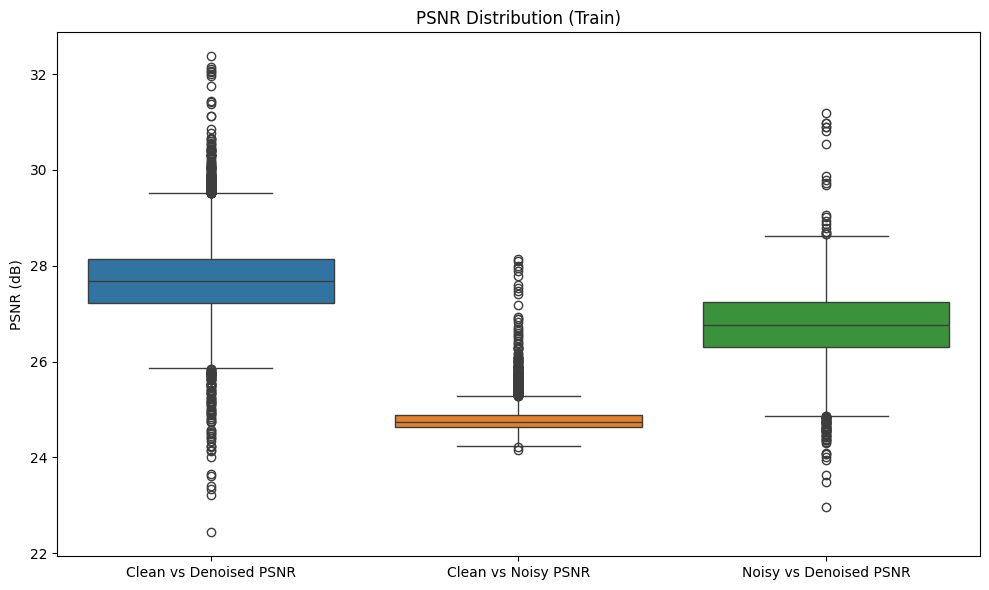

📈 PSNR box plot saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/train_psnr_boxplot.jpg


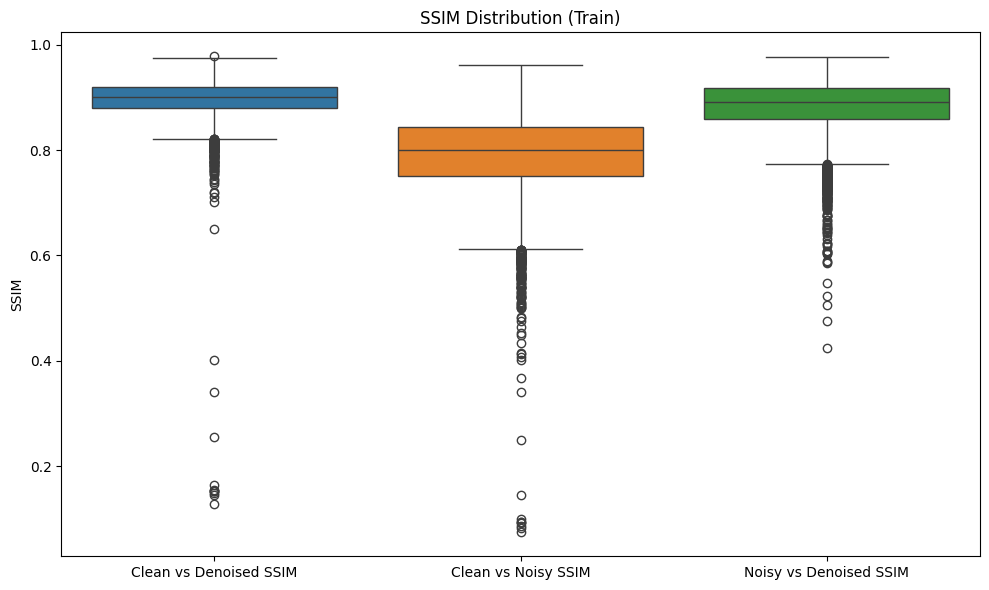

📈 SSIM box plot saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/train_ssim_boxplot.jpg


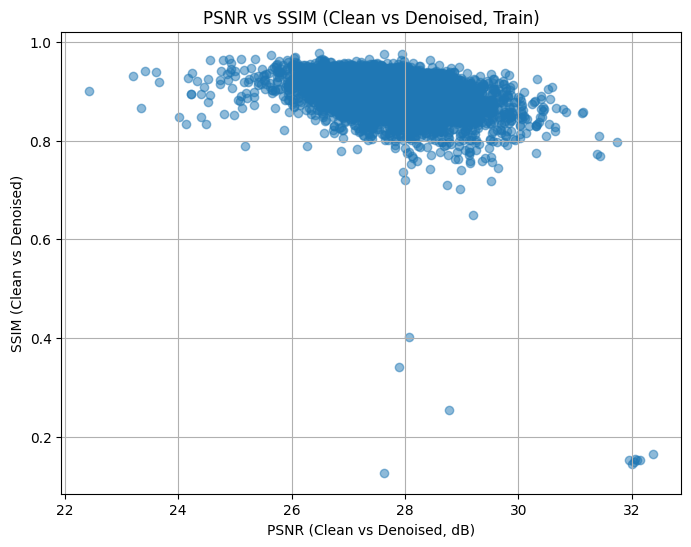

📈 Scatter plot saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/train_psnr_ssim_scatter.jpg

📊 Evaluation Results for Validate Split:
  🏋️‍♂️ MSE Loss (Clean vs Denoised): 0.001652
  📷 Clean vs Denoised PSNR: 27.88 dB
  🔍 Clean vs Denoised SSIM: 0.8915
  📷 Clean vs Noisy PSNR: 24.78 dB
  🔍 Clean vs Noisy SSIM: 0.7776
  📷 Noisy vs Denoised PSNR: 26.74 dB
  🔍 Noisy vs Denoised SSIM: 0.8720
  ⏱️ Avg Inference Time: 0.42 ms
📈 Metrics saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/validate_metrics.csv
  🖼️ Saved: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/validate_noisy_0.jpg
  🖼️ Saved: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/validate_clean_0.jpg
  🖼️ Saved: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/validate_denoised_0.jpg
  🖼️ Saved: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/validate_noisy_1.jpg
  🖼️ Saved: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/validate_clean_1.jpg
  

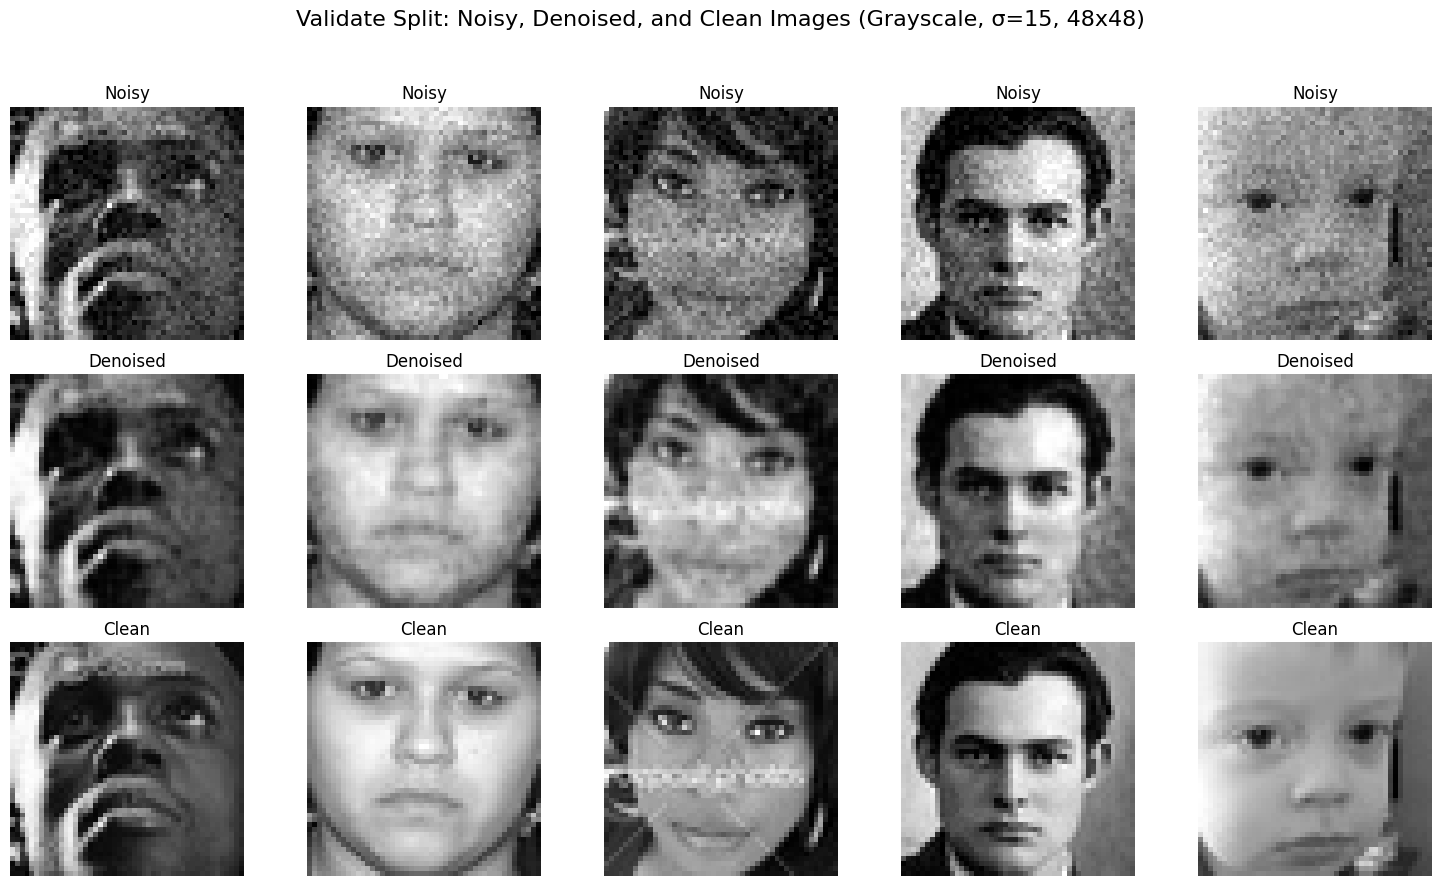

📈 Sample images saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/validate_samples.jpg


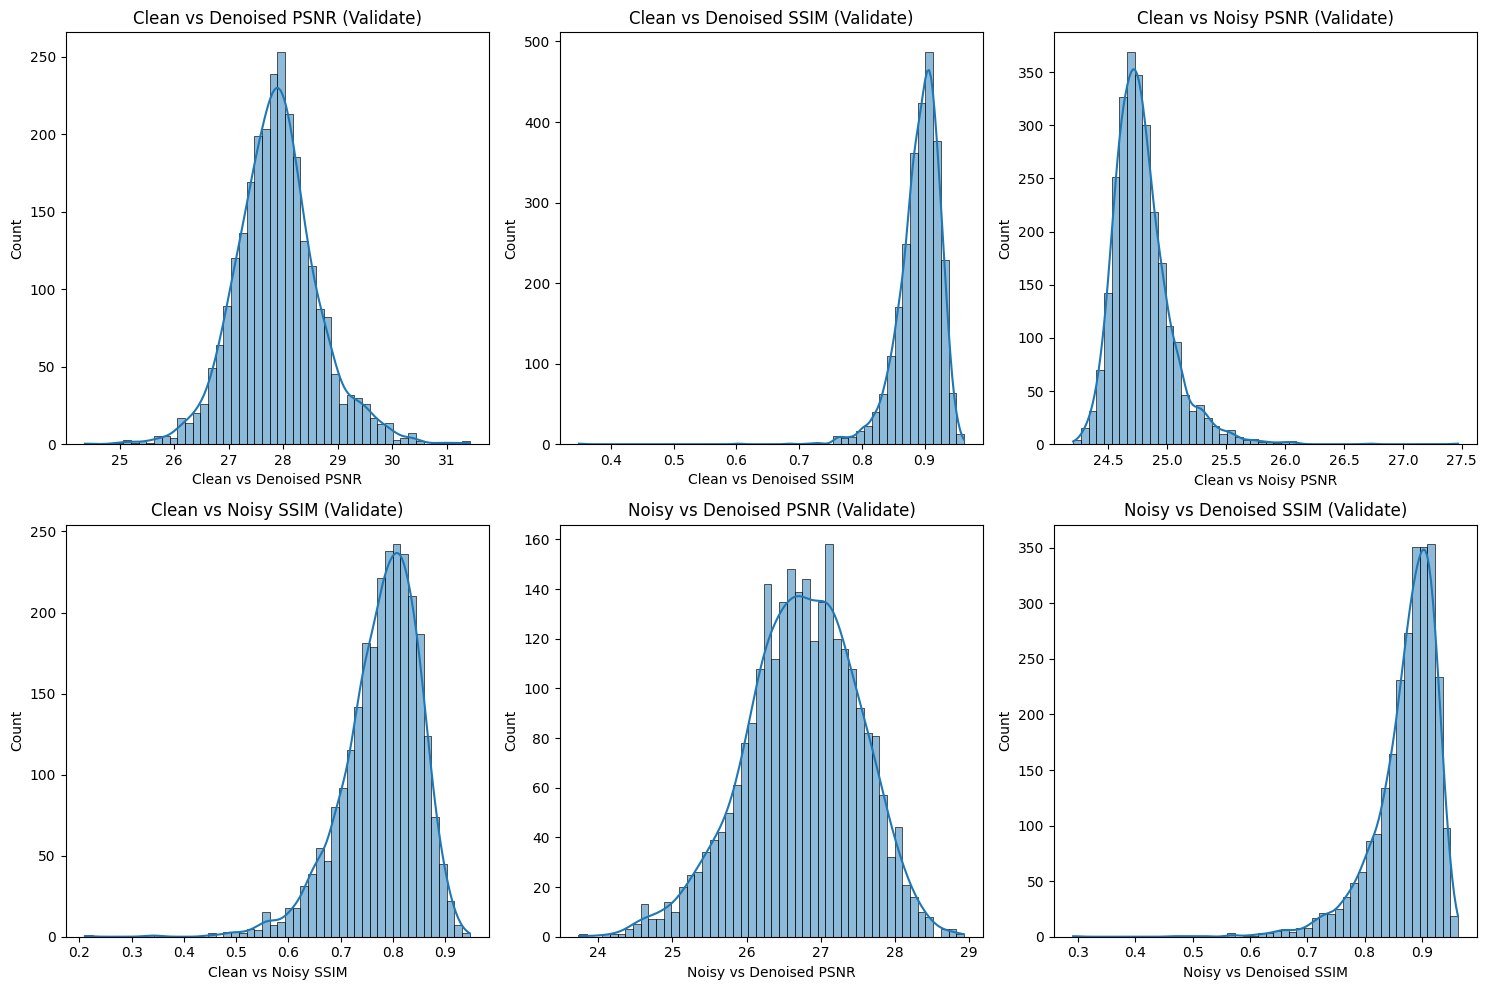

📈 Histograms saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/validate_histograms.jpg


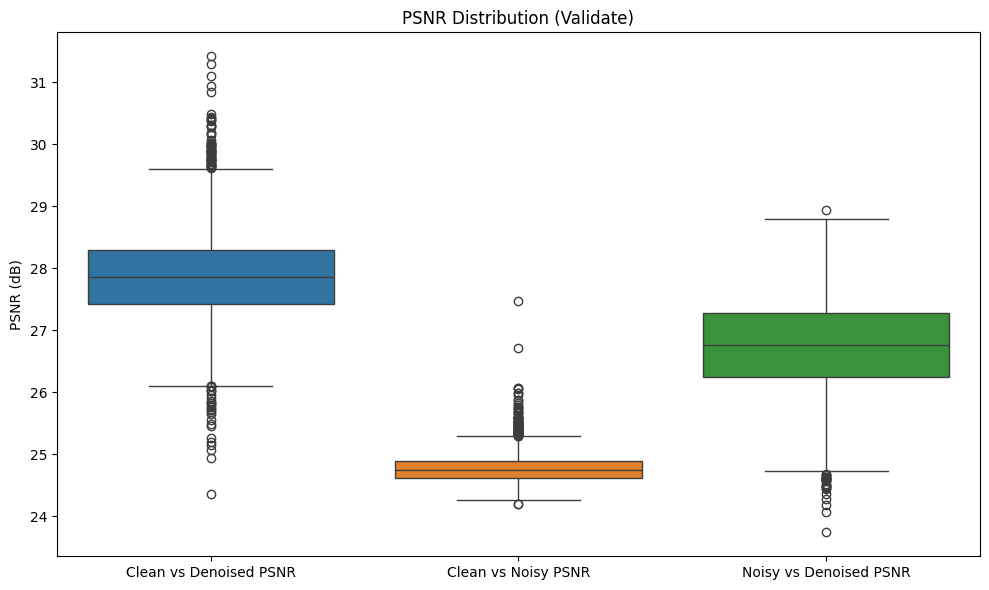

📈 PSNR box plot saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/validate_psnr_boxplot.jpg


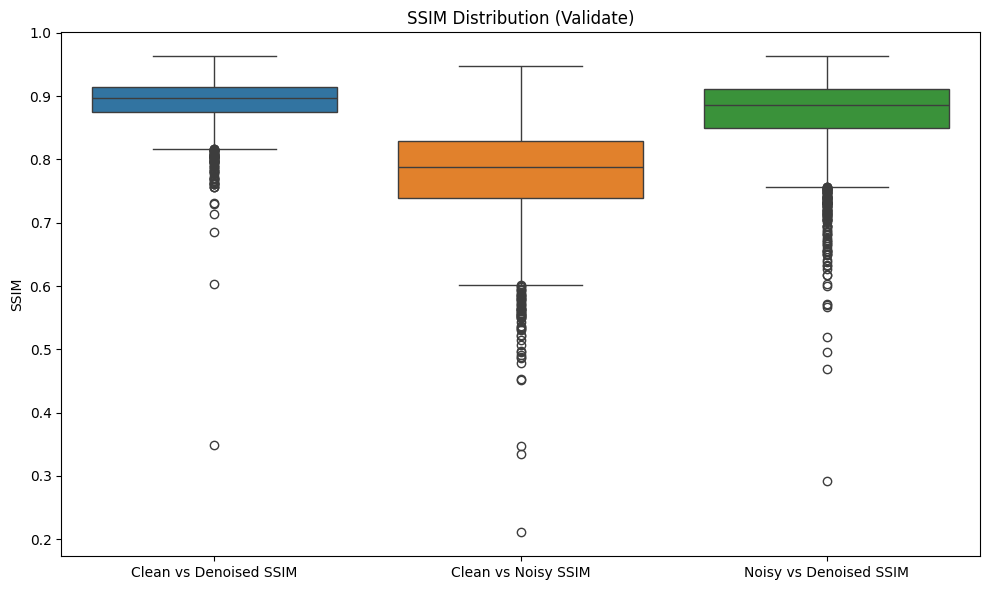

📈 SSIM box plot saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/validate_ssim_boxplot.jpg


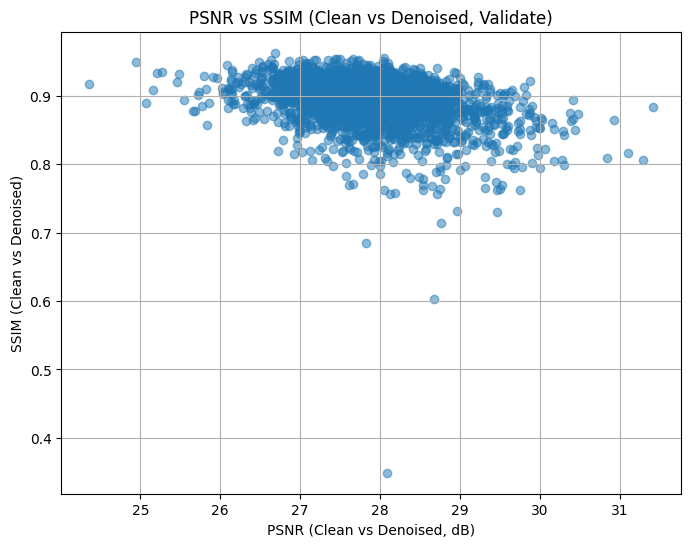

📈 Scatter plot saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/validate_psnr_ssim_scatter.jpg

📊 Evaluation Results for Test Split:
  🏋️‍♂️ MSE Loss (Clean vs Denoised): 0.001709
  📷 Clean vs Denoised PSNR: 27.74 dB
  🔍 Clean vs Denoised SSIM: 0.8966
  📷 Clean vs Noisy PSNR: 24.79 dB
  🔍 Clean vs Noisy SSIM: 0.7909
  📷 Noisy vs Denoised PSNR: 26.73 dB
  🔍 Noisy vs Denoised SSIM: 0.8808
  ⏱️ Avg Inference Time: 0.45 ms
📈 Metrics saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/test_metrics.csv
  🖼️ Saved: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/test_noisy_0.jpg
  🖼️ Saved: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/test_clean_0.jpg
  🖼️ Saved: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/test_denoised_0.jpg
  🖼️ Saved: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/test_noisy_1.jpg
  🖼️ Saved: /content/drive/MyDrive/denoised_samples_grayscale_sigma15/test_clean_1.jpg
  🖼️ Saved: /content/drive/

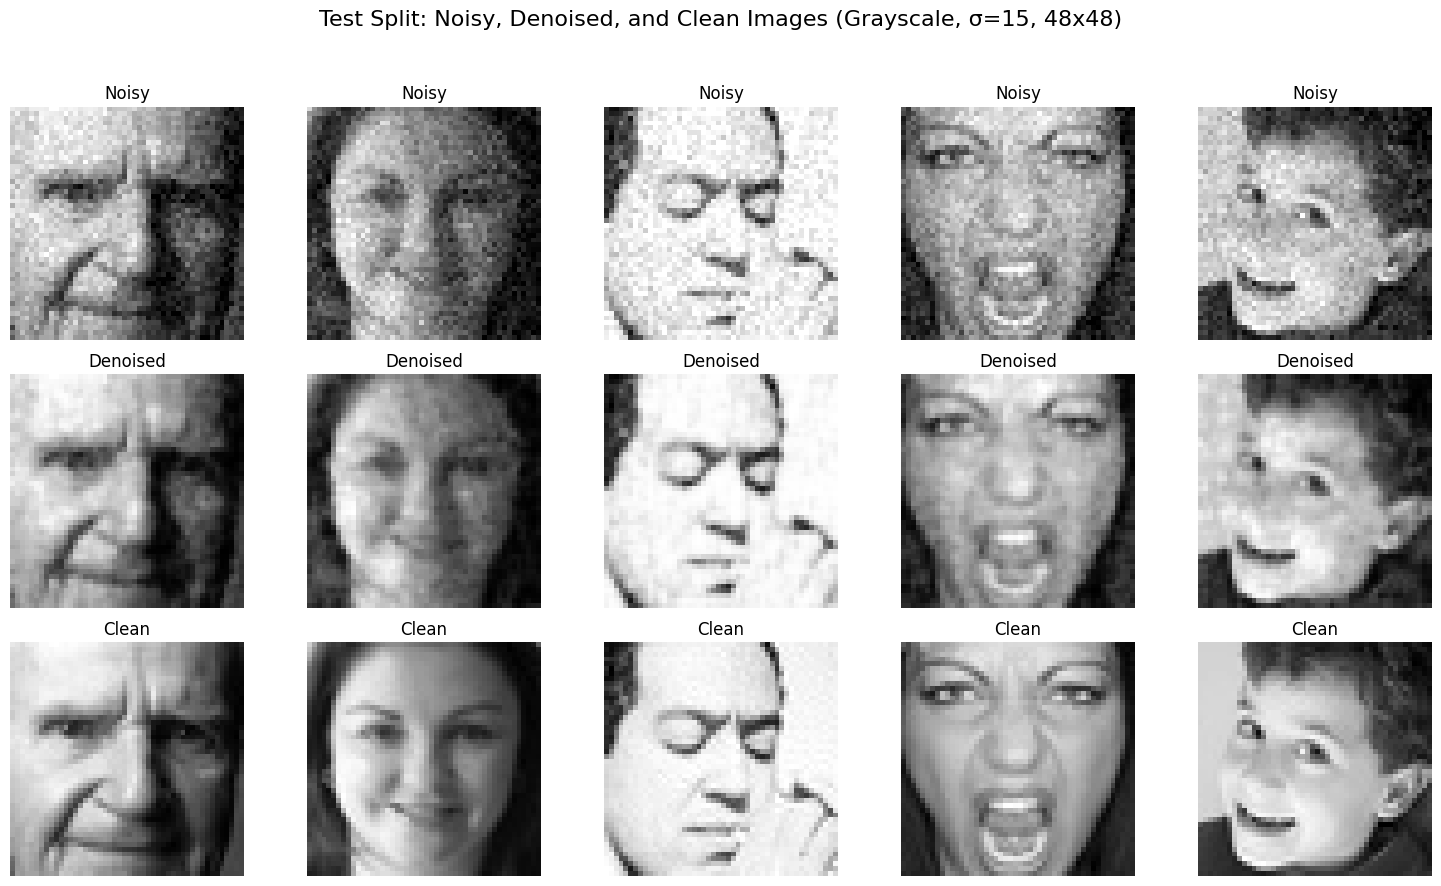

📈 Sample images saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/test_samples.jpg


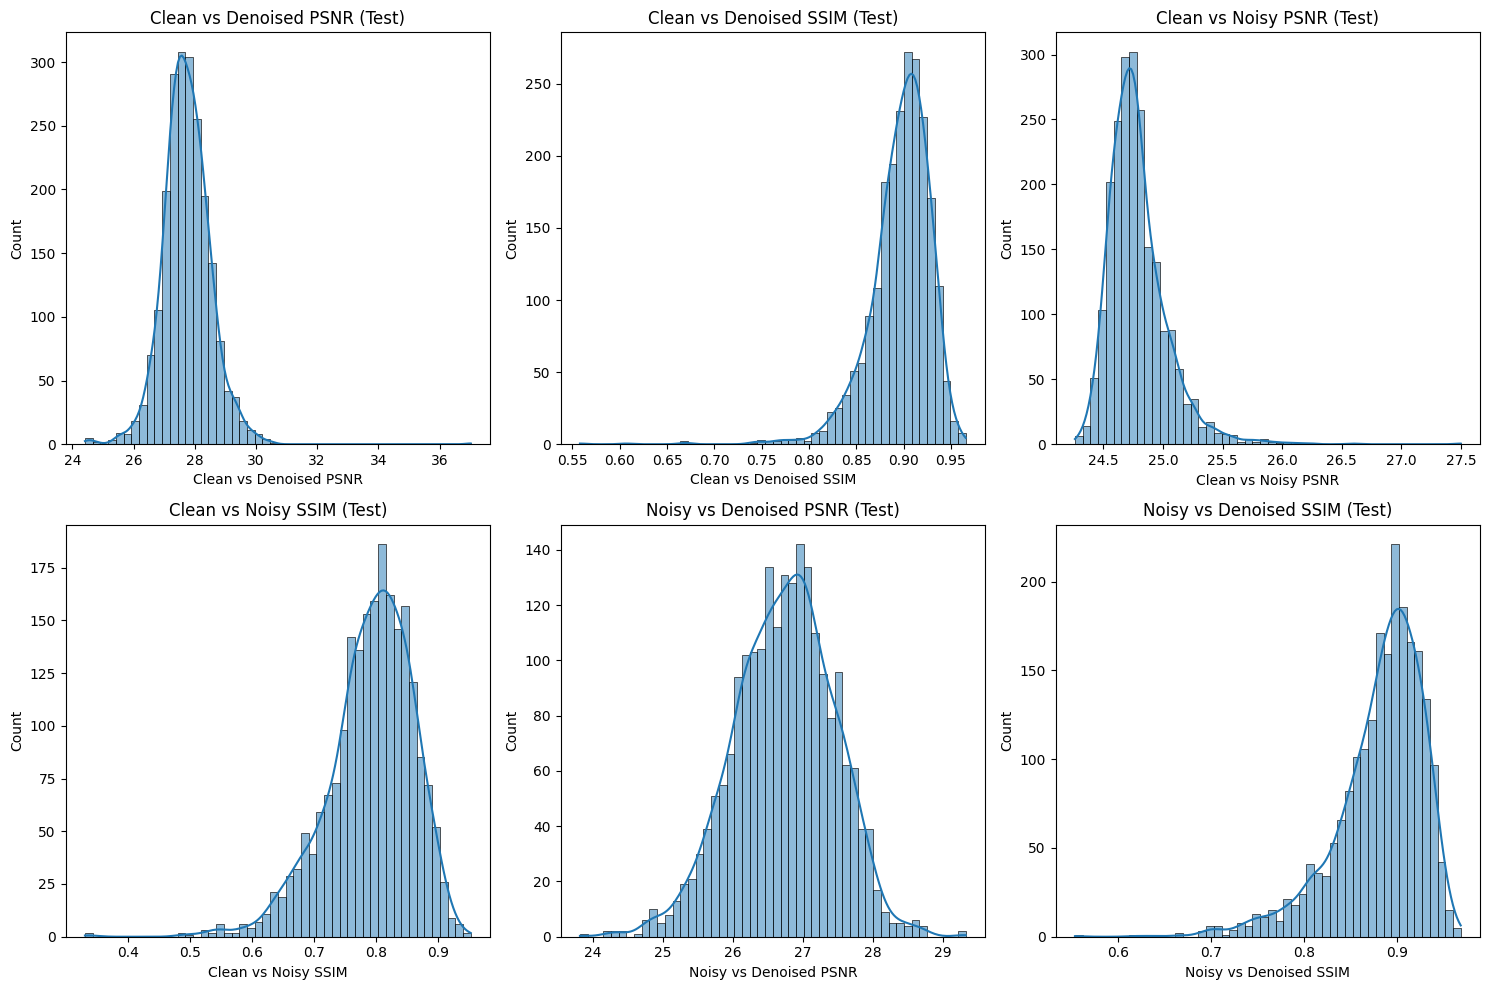

📈 Histograms saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/test_histograms.jpg


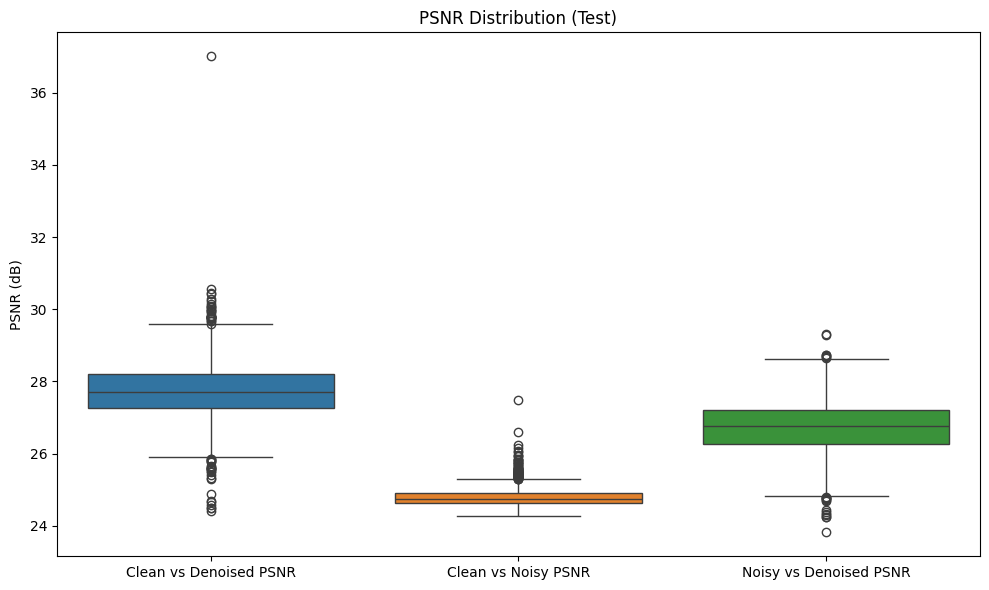

📈 PSNR box plot saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/test_psnr_boxplot.jpg


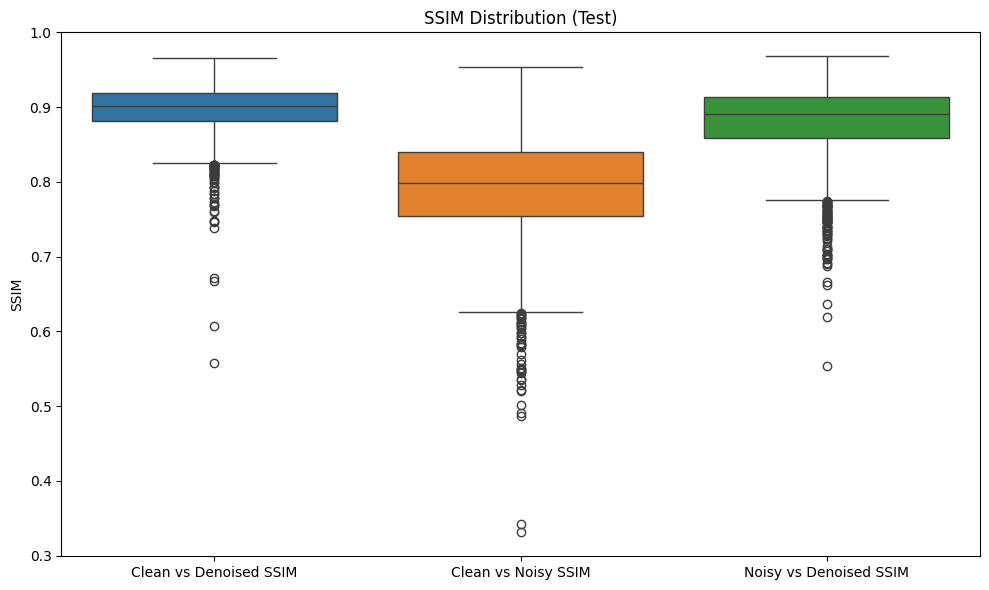

📈 SSIM box plot saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/test_ssim_boxplot.jpg


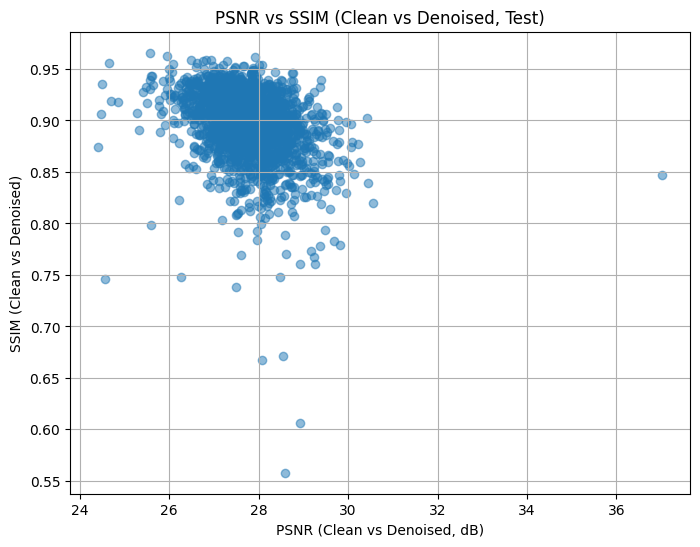

📈 Scatter plot saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15/test_psnr_ssim_scatter.jpg
✅ Evaluation complete. All results and plots saved to /content/drive/MyDrive/denoised_samples_grayscale_sigma15


In [65]:
import pandas as pd
import seaborn as sns
# Evaluate on all splits
for split_name, loader in [('Train', train_loader), ('Validate', val_loader), ('Test', test_loader)]:
    metrics, mse_loss = evaluate_model(model, loader, split_name, device)

print("✅ Evaluation complete. All results and plots saved to", output_dir)

In [67]:
# Print model architecture using torchsummary
from torchsummary import summary
print("Bi-MSAAE Model Architecture:")
summary(model, input_size=(1, 48, 48))

Bi-MSAAE Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 48, 48]              10
            Conv2d-2           [-1, 32, 48, 48]              64
       BatchNorm2d-3           [-1, 32, 48, 48]              64
              ReLU-4           [-1, 32, 48, 48]               0
            Conv2d-5            [-1, 1, 48, 48]              26
            Conv2d-6           [-1, 32, 48, 48]              64
       BatchNorm2d-7           [-1, 32, 48, 48]              64
              ReLU-8           [-1, 32, 48, 48]               0
 MultiScaleEncoder-9           [-1, 64, 48, 48]               0
           Conv2d-10           [-1, 64, 48, 48]           4,160
           Conv2d-11            [-1, 1, 48, 48]              65
          Sigmoid-12            [-1, 1, 48, 48]               0
  NoiseGateModule-13           [-1, 64, 48, 48]               0
AdaptiveAv